In [40]:
import re
import pandas as pd
import numpy as np
import seaborn as sns

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
import os
import os.path

path = "/content/sample_data/" 
os.chdir(path)

In [42]:
# Positive Case Keywords Only
positive_case_keywords = ['does have lyme', 'had lyme', 'has lyme', 'may have lyme', 'might have lyme', 'may have had lyme', 'had the lyme', 'having lyme', 'got lyme', 
                          'confirmed case of lyme', 'caught lyme', 'gave me lyme']

In [ ]:
# Create new train dataset with positive case keyword labels only

# Create new column with all tweets in lowercase
df = pd.read_csv('no_geopy_us_305k.csv')

lowercase_words = df['text'].str.lower()
df['lowercase_tweets'] = lowercase_words

# Dataframe with tweets relevant to Lyme disease only
# These tweets can be labeled as '1' for having relevance to Lyme disease for text classification model
lyme_disease_tweet_df = df[df.lowercase_tweets.str.contains('|'.join(positive_case_keywords))]

# Dataframe with tweets not relevant to Lyme disease
# These tweets can be labeled as '0' for having no relevance to Lyme disease for text classification model
non_lyme_disease_tweet_df = df[-df.lowercase_tweets.str.contains('|'.join(positive_case_keywords))]

df.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
       'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
       'referenced_tweets', 'context_annotations', 'entities', 'user',
       'user_name', 'user_location', 'city', 'state', 'county', 'country',
       'year', 'keywords_label', 'lowercase_tweets'],
      dtype='object')

In [ ]:
# Create Dataframe with Positive Lyme Tweets
lyme_disease_tweet_df['positive_keyword_label'] = 1
non_lyme_disease_tweet_df['positive_keyword_label'] = 0

pos_case_train_df = pd.concat([lyme_disease_tweet_df, non_lyme_disease_tweet_df])
len(pos_case_train_df), pos_case_train_df.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(305785, Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
        'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
        'referenced_tweets', 'context_annotations', 'entities', 'user',
        'user_name', 'user_location', 'city', 'state', 'county', 'country',
        'year', 'keywords_label', 'lowercase_tweets', 'positive_keyword_label'],
       dtype='object'))

In [ ]:
# Create CSV train dataset with Positive Case Labels
pos_case_train_df.to_csv('Positive_Keyword_from_NoGeoPy_305K.csv', index=False, header=True)

In [43]:
# Load the Positive Case Keywords Labeled Dataset
pos_case_train_df = pd.read_csv('Positive_Keyword_from_NoGeoPy_305K.csv')
print(pos_case_train_df.columns)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
       'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
       'referenced_tweets', 'context_annotations', 'entities', 'user',
       'user_name', 'user_location', 'city', 'state', 'county', 'country',
       'year', 'keywords_label', 'lowercase_tweets', 'positive_keyword_label'],
      dtype='object')


0    300500
1      5285
Name: positive_keyword_label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


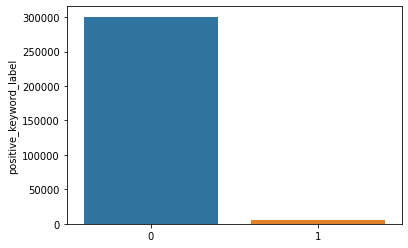

In [44]:
# Check if Lyme and non-Lyme tweets have balanced representation
x = pos_case_train_df['positive_keyword_label'].value_counts()
print(x)
sns.barplot(x.index,x);

0    5290
1    5285
Name: positive_keyword_label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


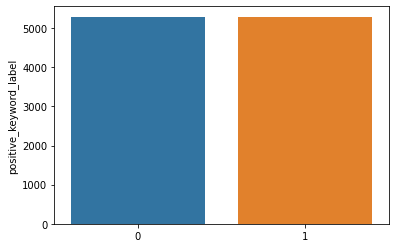

In [45]:
# Isolate 5285 tweets for training set (balanced and 529 tweets each from 2010 - 2019)
def random_tweet(lymecase, year):
    new_df = pos_case_train_df[(pos_case_train_df['positive_keyword_label'] == lymecase) & (pos_case_train_df['year'] == year)]
    return(new_df.sample(529, replace=False, random_state = 2)) # Randomize the data

years = list(range(2010, 2020))

# 10000 Non-Lyme Tweets Dataframe
appended_nonlyme_df = []
for x in years:
    year_df = random_tweet(0, x)
    appended_nonlyme_df.append(year_df)
    random_5k_no_lyme = pd.concat(appended_nonlyme_df)

# Combine the Dataframes to Create 10k Training Data
training_data_10k = pd.concat([pos_case_train_df[(pos_case_train_df['positive_keyword_label'] == 1)], random_5k_no_lyme])

# Check if Lyme and non-Lyme tweets have balanced representation
x = training_data_10k['positive_keyword_label'].value_counts()
print(x)
sns.barplot(x.index,x);

In [46]:
# Source/reference- https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

#Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = str(text)
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# Stopword Removal
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
    
#Lemmatization
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [47]:
# Remove any rows with NaN (empty string) values due to stopword preprocessing
training_data_10k['final_cleaned_text'] = training_data_10k['text'].apply(lambda x: finalpreprocess(x))
training_data_10k['final_cleaned_text'].replace('', np.nan, inplace=True)
training_data_10k.dropna(subset=['final_cleaned_text'], inplace=True)
len(training_data_10k)

10575

In [48]:
# Split dataset into train and test for NLP Classification Model
X_train, X_test, y_train, y_test = train_test_split(training_data_10k['final_cleaned_text'], training_data_10k['positive_keyword_label'], test_size=0.2, shuffle=True)

In [49]:
# Source/reference- https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

#TF-IDF Embedding
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [50]:
# Source/reference- https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

# Word2Vec Embedding
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

training_data_10k['clean_text_tok']=[nltk.word_tokenize(i) for i in training_data_10k['final_cleaned_text']]
model = Word2Vec(training_data_10k['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))     
modelw = MeanEmbeddingVectorizer(w2v)


# Tokenize sentences for Word2Vec
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

# Converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [51]:
# Function for predicting y value for test dataset and evaluating classification metrics
def predict_score(model, X_test_vector, y_test):
    global y_predict
    y_predict = model.predict(X_test_vector)
    global y_prob
    y_prob = model.predict_proba(X_test_vector)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    return (print(classification_report(y_test,y_predict)),
            print('Confusion Matrix:',confusion_matrix(y_test, y_predict)),
            print('AUC:', roc_auc))

In [75]:
lr_tfidf=LogisticRegression(solver = 'lbfgs', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(lr_tfidf, X_test_vectors_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1056
           1       0.83      0.86      0.84      1059

    accuracy                           0.84      2115
   macro avg       0.84      0.84      0.84      2115
weighted avg       0.84      0.84      0.84      2115

Confusion Matrix: [[866 190]
 [149 910]]
AUC: 0.91302990957736
(None, None, None)


In [71]:
# Fit the classification model via Logistic Regression (TF-IDF) without cross-validation
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(lr_tfidf, X_test_vectors_tfidf, y_test))

# Fit the classification model via Logistic Regression (TF-IDF) with cross-validation
lr_cv_tfidf=LogisticRegressionCV(solver = 'liblinear', cv=7, Cs=10, penalty = 'l2')
lr_cv_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(lr_cv_tfidf, X_test_vectors_tfidf, y_test))

# Fit the classification model using Naive Bayes (TF-IDF)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)
print(predict_score(nb_tfidf, X_test_vectors_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1056
           1       0.83      0.86      0.84      1059

    accuracy                           0.84      2115
   macro avg       0.84      0.84      0.84      2115
weighted avg       0.84      0.84      0.84      2115

Confusion Matrix: [[866 190]
 [149 910]]
AUC: 0.913012919563911
(None, None, None)
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1056
           1       0.83      0.87      0.85      1059

    accuracy                           0.85      2115
   macro avg       0.85      0.85      0.85      2115
weighted avg       0.85      0.85      0.85      2115

Confusion Matrix: [[867 189]
 [137 922]]
AUC: 0.9157518885741266
(None, None, None)
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1056
           1       0.77      0.90      0.83      1059

    accuracy   

In [53]:
# Create new test dataset with positive case keyword labels only

# Create new column with all tweets in lowercase
df2 = pd.read_csv('tweets_420k.csv')

lowercase_words = df2['text'].str.lower()
df2['lowercase_tweets'] = lowercase_words

# Dataframe with tweets relevant to Lyme disease only
# These tweets can be labeled as '1' for having relevance to Lyme disease for text classification model
lyme_disease_tweet_df = df2[df2.lowercase_tweets.str.contains('|'.join(positive_case_keywords))]

# Dataframe with tweets not relevant to Lyme disease
# These tweets can be labeled as '0' for having no relevance to Lyme disease for text classification model
non_lyme_disease_tweet_df = df2[-df2.lowercase_tweets.str.contains('|'.join(positive_case_keywords))]

df2.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
       'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
       'referenced_tweets', 'context_annotations', 'entities', 'user',
       'user_name', 'user_location', 'city', 'state', 'county', 'country',
       'cty_st', 'year', 'keywords_label', 'month', 'lowercase_tweets'],
      dtype='object')

In [54]:
# Create Dataframe with Positive Lyme Tweets
lyme_disease_tweet_df['positive_keyword_label'] = 1
non_lyme_disease_tweet_df['positive_keyword_label'] = 0

pos_case_test_df = pd.concat([lyme_disease_tweet_df, non_lyme_disease_tweet_df])
len(pos_case_test_df), pos_case_test_df.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(419461, Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
        'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
        'referenced_tweets', 'context_annotations', 'entities', 'user',
        'user_name', 'user_location', 'city', 'state', 'county', 'country',
        'cty_st', 'year', 'keywords_label', 'month', 'lowercase_tweets',
        'positive_keyword_label'],
       dtype='object'))

In [55]:
# Create CSV train dataset with Positive Case Labels
pos_case_test_df.to_csv('Positive_Keyword_from_GeoPy_420K.csv', index=False, header=True)

In [ ]:
# Load the 420k Dataset with Positive Lyme Tweets
pos_case_test_df = pd.read_csv('Positive_Keyword_from_GeoPy_420K.csv')
len(pos_case_test_df), pos_case_test_df.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(397165, Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
        'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
        'referenced_tweets', 'context_annotations', 'entities', 'user',
        'user_name', 'user_location', 'city', 'state', 'county', 'country',
        'cty_st', 'year', 'keywords_label', 'fixed_text', 'pred_label',
        'lowercase_tweets', 'positive_keyword_label'],
       dtype='object'))

0    411614
1      7847
Name: positive_keyword_label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


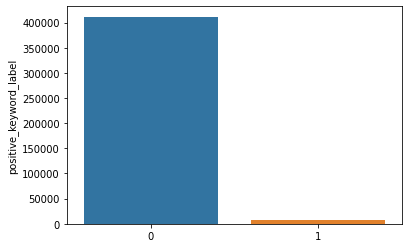

In [56]:
# Check if Lyme and non-Lyme tweets have balanced representation
x = pos_case_test_df['positive_keyword_label'].value_counts()
print(x)
sns.barplot(x.index,x);

0    7850
1    7847
Name: positive_keyword_label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


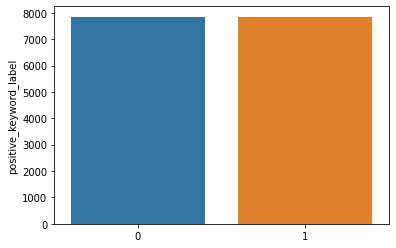

In [57]:
# Isolate 7847 tweets for training set (balanced and 785 tweets each from 2010 - 2019)
def random_tweet(lymecase, year):
    new_df = pos_case_test_df[(pos_case_test_df['positive_keyword_label'] == lymecase) & (pos_case_test_df['year'] == year)]
    return(new_df.sample(785, replace=False, random_state = 2)) # Randomize the data

years = list(range(2010, 2020))

# 7847 Non-Lyme Tweets Dataframe
appended_nonlyme_df = []
for x in years:
    year_df = random_tweet(0, x)
    appended_nonlyme_df.append(year_df)
    random_8k_no_lyme = pd.concat(appended_nonlyme_df)

# Combine the Dataframes to Create 15k Training Data
testing_data_15k = pd.concat([pos_case_test_df[(pos_case_test_df['positive_keyword_label'] == 1)], random_8k_no_lyme])

# Check if Lyme and non-Lyme tweets have balanced representation
x = testing_data_15k['positive_keyword_label'].value_counts()
print(x)
sns.barplot(x.index,x);

In [58]:
testing_data_15k.columns

Index(['id', 'text', 'author_id', 'public_metrics', 'created_at',
       'in_reply_to_user_id', 'conversation_id', 'reply_settings', 'source',
       'referenced_tweets', 'context_annotations', 'entities', 'user',
       'user_name', 'user_location', 'city', 'state', 'county', 'country',
       'cty_st', 'year', 'keywords_label', 'month', 'lowercase_tweets',
       'positive_keyword_label'],
      dtype='object')

In [59]:
# Test TF-IDF Log Reg (without cross-validation) on Positive Cases
# Pre-process the test dataset
testing_data_15k['final_cleaned_text'] = testing_data_15k['text'].apply(lambda x: finalpreprocess(x))
X_test = testing_data_15k['final_cleaned_text']

# Convert words to numerical data using TF-IDF
X_vector=tfidf_vectorizer.transform(X_test)

# Use models to predict class value for the test dataset 
predict_score(lr_tfidf, X_vector, testing_data_15k['positive_keyword_label'])

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      7850
           1       0.80      0.83      0.82      7847

    accuracy                           0.81     15697
   macro avg       0.81      0.81      0.81     15697
weighted avg       0.81      0.81      0.81     15697

Confusion Matrix: [[6231 1619]
 [1329 6518]]
AUC: 0.8842377832739032


(None, None, None)

In [76]:
# Use models to predict class value for the test dataset 
predict_score(lr_cv_tfidf, X_vector, testing_data_15k['positive_keyword_label'])

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      7850
           1       0.80      0.84      0.82      7847

    accuracy                           0.82     15697
   macro avg       0.82      0.82      0.82     15697
weighted avg       0.82      0.82      0.82     15697

Confusion Matrix: [[6260 1590]
 [1287 6560]]
AUC: 0.889673460343074


(None, None, None)